# Tutorial

This tutorial is also a Jupyter notebook, which can be found in [the example notebooks directory](https://github.com/annegambrel/xfaster/tree/main/example/notebooks).

The notebook reads intermediate output npz files from disk. To instead run the pieces starting from maps, first generate the example maps by running the script `xfaster/example/make_example_maps.py`, and set the checkpoint to something other than None.

## The main ingredients of the XFaster code

Before we get into the functions that produce each of the components that gets fed into the equations for bandpower deviations, $q_b$ and the Fisher matrix (Equations 17 and 18 in the [Algorithm section](../algorithm.rst)), let's first talk about how XFaster is structured and what it expects as inputs.

There are two main python modules in XFaster: [xfaster_exec.py](../api.rst#module-xfaster.xfaster_exec) and [xfaster_class.py](../api.rst#module-xfaster.xfaster_class). [xfaster_exec.py](../api.rst#module-xfaster.xfaster_exec) contains two main functions: [xfaster_run](../api.rst#xfaster.xfaster_exec.xfaster_run) and [xfaster_submit](../api.rst#xfaster.xfaster_exec.xfaster_submit). [xfaster_run](../api.rst#xfaster.xfaster_exec.xfaster_run) calls all of the functions to make XFaster happen (all located in [xfaster_class.py](../api.rst#module-xfaster.xfaster_class)) in the order they need to happen. [xfaster_submit](../api.rst#xfaster.xfaster_exec.xfaster_submit) takes arguments for submitting the job to a queue. XFaster is not highly parallelized. However, significant speed-up is gained from using more cores in the simulation pseudo-spectrum calculation through under-the-hood use of OMP. Therefore, if you're starting from a checkpoint after "sims", no significant speed-up will be gained when using more cores. 

There are a few other modules you might interact with: 
* [parse_tools.py](../api.rst#module-xfaster.parse_tools): contains a bunch of tools for converting between data structures, especially between dictionaries and matrices
* [xfaster_tools.py](../api.rst#module-xfaster.xfaster_tools): contains small functions used in xfaster_class

## Specifying what data to use

The top level module you interact with is [xfaster_exec.py](../api.rst#module-xfaster.xfaster_exec), which takes your arguments, and has some reasonable defaults for any you don't provide. In addition to arguments, you must point the code to the inputs you want to run on. The first of these inputs is maps.

### Maps

The main inputs to the code are maps-- data maps, signal and noise simulations, and masks. Rather than pointing to each map individually, there is a directory structure that the code expects. Its contents look like this:

    <data_root>/
    ├── data_<data_type>
    │   ├── <data_subset1>
    │   │   ├── map_<tag1>.fits
    │   │   ├── ...
    │   │   ├── map_<tagN>.fits
    │   ├── <data_subset2> (same filenames as <data_subset1>)
    │   ├── ....
    │   ├── <data_subsetM>
    ├── signal_<signal_type>
    │   ├── spec_signal_<signal_type>.dat
    │   ├── <data_subset1>
    │   │   ├── map_<tag1>_0000.fits
    │   │   ├── ...
    │   │   ├── map_<tag1>_####.fits
    │   │   ├── ...
    │   │   ├── map_<tagN>_0000.fits
    │   │   ├── ...
    │   │   ├── map_<tagN>_####.fits
    │   ├── ....
    │   ├── <data_subsetM> (same filenames as <data_subset1>)
    ├── noise_<noise_type> (same filenames as signal_<signal_type>)
    ├── masks_<mask_type>
    │   ├── mask_map_<tag1>.fits
    │   ├── ...
    │   ├── mask_map_<tagN>.fits
    [[optional:]]
    ├── foreground_<foreground_type> (same filenames as signal_<signal_type>
    ├── templates_<template_type>
    │   ├── halfmission-1 (same filenames as data_<data_type>)
    │   ├── halfmission-2 (same filenames as data_<data_type>)
    └── reobs_planck (same filenames as templates_<template_type>, used if sub_planck=True for null tests)

Each of `data`, `signal`, `noise`, and `mask` has a top level directory with a preordained, fixed prefix (`data`, `signal`, `noise`, `mask`) and then some suffix specified by the user which is appended with an underscore. So, for example, to run XFaster on the example set of maps, I need to specify in my arguments: `data_type=raw`, `signal_type=synfast`, `noise_type=gaussian`, `mask_type=rectangle`.

All maps must be HEALPIX fits files. Data maps must be named `map_<tag>.fits`; simulated signal and noise maps must be named `map_<tag>_####.fits`, where #### is any length numerical tag indicating a sim realization; and masks are labeled `mask_map_<tag>.fits`.

If using `pol=True`, masks must be 3 x Npix I,Q,U maps. You can use a different mask for intensity and polarization, in which case your mask must be 2 x Npix, where the first row is used for T and the second for P.

To indicate which maps you want, pass the argument `data_subset` a glob-parseable path relative to the top level data directory-- in this case, `data_raw`. [Glob](https://docs.python.org/3/library/glob.html) works just like the unix shell does for matching file paths, so it is easy to test in advance which maps you're going to get. Just do `ls <path_to_data_maps>/full/*150*` and check that all the maps you want to use are listed. Then, you should set `data_subset` to `full/*150*`, for example.

This is all implemented in `_get_files()` (called by [get_files()](../api.rst#xfaster.xfaster_class.XFaster.get_files)) like so:
```python


# find all map files                                                               
map_root = os.path.join(data_root, "data_{}".format(data_type))
map_files = []
data_subset = data_subset.split(",")
for f in np.atleast_1d(data_subset):
    files = glob.glob(os.path.join(map_root, "{}.fits".format(f)))
    if not len(files):
        raise OSError("Missing files in data subset {}".format(f))
    map_files.extend(files)
data_subset = ",".join(data_subset)
map_files = sorted(map_files)
map_files = [f for f in map_files if os.path.basename(f).startswith("map_")]
map_tags = [
    os.path.splitext(os.path.basename(f))[0].split("_", 1)[1] for f in map_files
]

```
So you've specified which data maps you want to compute power spectra for. To get the corresponding sim maps, the code takes whatever data maps were found matching data_subset, and tries to match those to maps in the sims directory, with the only difference the sim index tag. Here's what that looks like for signal sims, in the same function:
```python
# find all corresponding signal sims
signal_root = os.path.join(data_root, "signal_{}".format(signal_type))
num_signal = None
signal_files = []
for f in map_files:
    sfiles = sorted(
        glob.glob(
            f.replace(map_root, signal_root).replace(
                ".fits", "_{}.fits".format(signal_subset))))
    nsims1 = len(sfiles)
    if not nsims1:
        raise OSError("Missing signal sims for {}".format(f))
    ...
    signal_files.append(sfiles)
```

It's easy to get errors at the reading files step. XFaster requires that all your maps have the same number of sims, though you are allowed to have a different from of signal and noise sims. If you do not want to use the full set of signal and noise maps in a directory, if you can set the `signal_subset` and `noise_subset` arguments, which default to `'*'`. This glob-parseable tag is applied to the `####` sim index tag. So, if I have a set of sims, eg, `map_95_0000.fits`-`map_95_0099.fits`, as in the example, but for some reason I only want to use the first 50, I can set `signal_subset='00[0-4]*`.

### Other inputs

In addition to maps, the code also requires a config file. This tells the code everything else it needs to know about your data. Here's the config file for the example:

```python

# Band centers in GHz (needed for foreground fitting) for each map tag.                    
# Tags listed here should be a superset of tags that may be included in a run.             
[frequencies]
95 = 94.7
150 = 151.0

# A numpy dictionary containing Bl for each map tag.                                       
# Keys should match those in freqs.                                                        
# Missing keys should have a fwhm listed below.                                            
# The value for each key should be a numpy array of dimensions (3, lmax + 1),              
# for TT, TP and PP beam windows.                                                          
[beam]
beam_product = None
beam_error_product = None

# FHWM in arcmin for each map tag, if using Gaussian beam model.                           
# Keys should match those in freqs.                                                        
# Missing keys should be in the beam product file.                                         
[fwhm]
95 = 41
150 = 29

# Fractional error on the FWHM for each map tag, if using a Gaussian beam model.           
# Keys should match those in freqs.                                                        
# Missing keys should be in the beam product file.                                         
[fwhm_err]
95 = 0.001
150 = 0.001

# Whether to compute transfer function qb parameters for each map tag.                     
# Keys should match those in freqs.                                                        
[transfer]
95 = true
150 = true
```

This is the full list of options that can be specified in the config file. 

## Step by step through the functions called in xfaster_exec
### Setup and checkpoints

Now we'll proceed to stepping through each function in [xfaster_exec](../api.rst#module-xfaster.xfaster_exec). You'll never run the code this way--you'll just call [xfaster_run](../api.rst#xfaster.xfaster_exec.xfaster_run) or [xfaster_submit](../api.rst#xfaster.xfaster_exec.xfaster_submit) with the arguments that then get passed to these functions. But we'll do it this way so we can illustrate some of the intermediate data products as we go.

This tutorial will follow the example script in [xfaster/example](https://github.com/annegambrel/xfaster/tree/main/example). Note however that becasue maps are not stored in the repository, this notebook is instead reading from the intermediate files written to disk. 

First, we'll import XFaster and initialize our XFaster class with some arguments.

In [1]:
import xfaster as xf
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

In [2]:
X = xf.XFaster(config="../config_example.ini", output_root="../outputs_example", verbose="info",
              output_tag="95x150", lmax=500, checkpoint=None)

At the start of an XFaster run, you can specify at what checkpoint to start. The checkpoints are:
```python
checkpoints = [
	"files", # find all the map files
	"masks", # load in masks and compute their pseudo-spectra
	"kernels", # compute mask mode-coupling kernels
	"sims_transfer", # compute pseudo-spectra for signal sims used for computing the transfer function
	"shape_transfer", # load in the model spectrum for the transfer function
	"transfer", # compute the transfer function
	"sims", # compute pseudo-spectra for noise sims and signal sims if they're different from those used for the transfer function
    "beams", # load in the beam window functions, and apply a pixel window function if pixwin=True
    "data", # compute the pseudo-spectra of the data maps
    "template_noise", # compute the pseudo-spectra of template noise simulations, if using Planck dust templates
    "shape", # load in the model spectrum for bandpower computation
	"bandpowers", # do the Fisher iteration to compute bandpowers
	"beam_errors", # start the likelihood over including beam error parameterization
	"likelihood", # compute the parameter likelihoods
]
```

Note that there are options to use different signal simulations for computing the transfer function and for computing other signal terms. This is mainly useful for null tests, as that's the only mode in which signal sims are used for anything other than transfer functions (to compute the expected signal residual that is subtracted from the data pseudo-spectra). If the signal simulations lack sufficient power (eg., for BB), the transfer function may not converge due to lack of measurable power. This is not a problem unique to XFaster, and this option allows the user more flexibility in the choice of sims used for different parts of the algorithm.

Most of the time, `checkpoint` can be set to None, which starts the code from the last checkpoint completed (ie, it successfully wrote its intermediate data to disk). However, if you've made changes to the code or inputs, you may wish to force the code to start from an earlier checkpoint. It will then run that checkpoint and every one after it in the checkpoint tree (given near the top of [the XFaster class](../api.rst#xfaster.xfaster_class.XFaster)).

### get_files

The first function called after initializing the XFaster class is [get_files()](../api.rst#xfaster.xfaster_class.XFaster.get_files). This takes all your arguments specifying what maps to use and finds them all on disk/checks that they're there.

In [3]:
file_opts = {
    "data_root": "../maps_example",
    "data_subset": "full/*95,full/*150",
    "data_type": "raw",
    "noise_type": "gaussian",
    "mask_type": "rectangle",
    "signal_type": "synfast",
}


In [4]:
file_vars = X.get_files(**file_opts)

In [5]:
file_vars.keys()

dict_keys(['data_root', 'data_subset', 'map_root', 'map_files', 'map_tags', 'map_pairs', 'map_tags_orig', 'map_pairs_orig', 'map_freqs', 'raw_root', 'raw_files', 'signal_root', 'signal_root_sim', 'signal_transfer_root', 'noise_root', 'noise_root_sim', 'mask_root', 'mask_files', 'foreground_root', 'data_type', 'noise_type', 'noise_type_sim', 'mask_type', 'signal_type', 'signal_type_sim', 'signal_transfer_type', 'signal_subset', 'noise_subset', 'foreground_type_sim', 'num_maps', 'num_signal', 'num_signal_transfer', 'num_noise', 'num_noise_sim', 'num_signal_sim', 'num_foreground', 'num_corr', 'num_spec', 'num_spec_mask', 'num_kern', 'data_shape', 'mask_shape', 'kern_shape', 'null_run', 'template_type', 'template_root', 'template_root2', 'template_files', 'template_files2', 'template_noise_root', 'template_noise_root2', 'template_noise_files', 'template_noise_files2', 'num_template', 'num_template_noise', 'planck_root1_hm1', 'planck_root2_hm1', 'planck_root1_hm2', 'planck_root2_hm2', 'plan

`file_vars` is a dictionary returned by `get_files` that is also written to disk to finish the checkpoint. There are a lot of things stored in this dictionary that are mainly used internally by the code and aren't useful to an end user. For example, `num_corr` is the number of crosss-correlations of maps, which is used as a dimension to set up data structures later on. But, some of these things might be useful for debuggin. For example, all of the files found using your glob-parseable file tags are stored here, so you can see exactly what maps are being used for data:

In [6]:
file_vars['map_files']

array(['../maps_example/data_raw/full/map_150.fits',
       '../maps_example/data_raw/full/map_95.fits'], dtype='<U42')

Other options you might use here are 
* `template_type`, which points to files stored in `template_<template_type>` for foreground template subtraction
* `data_root2`, which is used for null tests. This points to a second full map directory (data, signal and noise sims) for a set of data to be subtracted from the maps in data_root1.
* `signal_type_sim`/`noise_type_sim`/`foreground_type_sim`-- these are tags corresponding to directories `signal_<signal_type_sim>`, `noise_<noise_type_sim>`, and `foreground_<foreground_type_sim>` that are used when the `sim_index` argument is set in the `bandpowers` checkpoint. This mode uses sim maps in place of data maps. It adds the signal, noise, and/or foreground sims in alm-space if `sims_add_alms=True`, which is the default, or in Cls, if it is False. These options are not needed to run in `sim_index` mode-- if they are not set, they default to `signal_type_sim=signal_type`, `noise_type_sim=noise_type`, and `foreground_type_sim=None`.

### get_bin_def

Now we run [get_bin_def()](../api.rst#xfaster.xfaster_class.XFaster.get_bin_def) set up a dictionary that tells where the edges of the CMB bins are for each spectrum. We can also choose whether to fit for noise residuals or foregrounds, which we can set to have different bin widths than the CMB bins.

In [7]:
bd = X.get_bin_def(bin_width=25, lmin=2, tbeb=True, foreground_fit=False, 
                   residual_fit=True, bin_width_res=100)

In [8]:
bd.keys()

odict_keys(['cmb_tt', 'cmb_ee', 'cmb_bb', 'cmb_te', 'cmb_eb', 'cmb_tb', 'res_eebb_150', 'res_eebb_95'])

In [9]:
bd['cmb_tt']

array([[  2,  27],
       [ 27,  52],
       [ 52,  77],
       [ 77, 102],
       [102, 127],
       [127, 152],
       [152, 177],
       [177, 202],
       [202, 227],
       [227, 252],
       [252, 277],
       [277, 302],
       [302, 327],
       [327, 352],
       [352, 377],
       [377, 402],
       [402, 427],
       [427, 452],
       [452, 477],
       [477, 501]])

This dictionary has a key for each type of spectrum that will be fit, each of which stores the bin edges used for that spectrum fit. Each of these bin edge pairs represents a separate bandpower deviation ($q_b$) that will be fit.

Residuals are fit per map, and by default are fit only for EE and BB, which are constrained to have the same fit parameter. To change this, use the option `res_specs`, which takes a list of the spectra you want to fit residuals for, ie. `["TT", "EE", "BB"]` if you'd like to fit all of the spectra separately.

The last option you might wish to use is `weighted_bins`, which changes the default $\chi_b(\ell)$ binning operator from a tophat to one that weights by $\ell(\ell+1)$.

### get_mask_weights

We have now finished all the set-up. Now it's time to start calculating things. First, we compute the cross spectra of our masks--which will be needed for computing the $K_{\ell \ell^{\prime}}$ mode-coupling matrix--and the $g_\ell$ mode-counting factor. This is done with [get_mask_weights()](../api.rst#xfaster.xfaster_class.XFaster.get_mask_weights).

For the example, we will not apply an empirical correction to $g_\ell$, the calibration of which is discussed in Section 2.3.2 of the [XFaster paper](https://arxiv.org/abs/2104.01172). Otherwise, we would set `apply_gcorr=True`, and the code would look in the masks directory for this correction file for each map. The `reload_gcorr` option is only useful when doing the empirical calibration; it reloads the file, while by-passing the checkpoint tree that is usually performed after `get_mask_weights`.

In [10]:
w_stuff = X.get_mask_weights(apply_gcorr=False, reload_gcorr=False)

In [11]:
w_stuff.keys()

dict_keys(['wls', 'fsky', 'w1', 'w2', 'w4', 'gmat', 'nside', 'npix', 'gcorr', 'output_file'])

`w1`, `w2`, and `w4` are the first, second, and fourth moments of the mask. `fsky` is the fraction of sky the mask covers. These are needed for computing the $g_\ell$ mode-counting term, labeled `gmat` in the outputs. `gmat` includes the $2\ell+1$ factor and a correction factor, if desired.

`wls`, contains the cross spectra of all the masks. For this and all other pseudo-spectra, the spectrum is computed just as `map2alm`, and then `alm2cl` healpy routines on the maps. If you're doing a polarized spectrum, you'll get three elements, (intensity, pol, intensity x pol). Since our intensity and pol masks are the same, all three elements are the same, and look like this (plotted as $D_\ell$):

Text(0.5, 0, '$\\ell$')

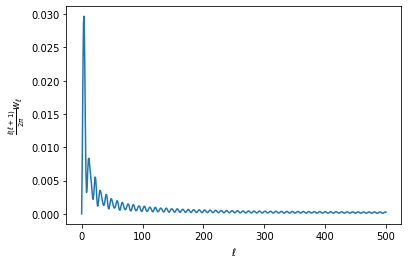

In [12]:
ell = np.arange(501)
lfac = ell * (ell+1) / (2*np.pi)
plt.plot(lfac * w_stuff['wls']['150:150'][0])
plt.ylabel(r'$\frac{\ell(\ell+1)}{2\pi}w_\ell$')
plt.xlabel(r'$\ell$')

**Note:** most of the quantities in XFaster are ordered dictionaries with the following nested structure:
1. Spectra (either plain ['tt', 'ee'], etc, or ['cmb_tt', 'cmb_ee', ..., 'fg_tt', 'fg_ee', ..., 'res_tt', ...]
2. Map/map cross. Crosses are indicated with a colon and are in alphabetical order (so 95 comes after 150, for example): ['150:150', '150:95', '95:95']
3. Stuff. Typically an array, though depending on the data structure, it could be a more deeply nested dictionary.

### get_kernels

The next step is to compute the kernels for each mask auto and cross spectrum using the function [get_kernels()](../api.rst#xfaster.xfaster_class.XFaster.get_kernels).  In the MASTER formalism, the kernel couples modes to each other on the sky due to the finite dimensions of the mask that is applied to each map that goes into computing a cross spectrum.  That is to say, the measured power at a particular $\ell$ is a weighted average over several other neighboring modes $\ell^\prime$, and $K_{\ell\ell^\prime}$ is the matrix that applies this weighting.

The kernels are computed from the power spectrum of the mask, computed in the previous step.

Let's plot some of these up.  Because we are using the same mask for all maps, the kernels for each $ij$ pair will look identical.

In [13]:
k = X.get_kernels()

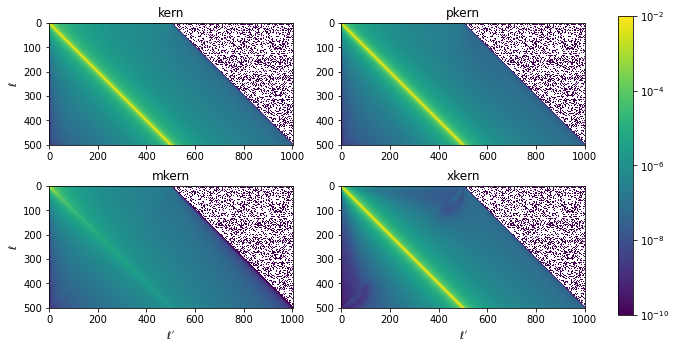

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(12,5.5))
m = ax[0,0].imshow(k['kern']['150:150'], norm=colors.LogNorm(vmax=0.01, vmin=1e-10))
ax[0,0].set_title('kern')
ax[0,0].set_ylabel('$\ell$')
ax[0,1].imshow(k['pkern']['150:150'], norm=colors.LogNorm(vmax=0.01, vmin=1e-10))
ax[0,1].set_title('pkern')
ax[1,0].imshow(k['mkern']['150:150'], norm=colors.LogNorm(vmax=0.01, vmin=1e-10))
ax[1,0].set_title('mkern')
ax[1,0].set_ylabel('$\ell$')
ax[1,0].set_xlabel('$\ell^\prime$')
ax[1,1].imshow(np.abs(k['xkern']['150:150']), norm=colors.LogNorm(vmax=0.01, vmin=1e-10))
ax[1,1].set_title('xkern')
ax[1,1].set_xlabel('$\ell^\prime$')
fig.colorbar(m, ax=ax.ravel().tolist());

Note that the shorter dimension ($\ell$) of each kernel goes up to $\ell_{max}$, and the longer dimension ($\ell^\prime$) extends to $2 \ell_{max} + 1$.  The kernels are apodized, so that for any row $\ell$, the kernels are zero for values $\ell^\prime > \ell + \ell_{max}$.  The longer dimension is summed over in computing the $\tilde{\mathcal{C}}_{b\ell}$ terms.

### get_masked_sims

Now we want to get the ensemble average of all of our signal simulations, which we're going to use to calculate the filter transfer function and also to build the CMB signal model we are comparing our data to. The same function, `get_masked_sims` computes the $\tilde{\mathcal{C}}_\ell$s for signal and noise. To start with, we just want the signal ensemble, so get_masked_sims is called as such:

In [15]:
s = X.get_masked_sims(transfer=True, do_noise=False)

This function is doing a very simple thing. For each pair of maps of a given sim index, it 
1. Applies the mask.
2. Transforms the maps into $a_{\ell m}$s using the healpy routine `map2alm`.
3. Transforms those into $\tilde{\mathcal{C}}_\ell$s for that pair using the healpy routine `alm2cl`.
4. Adds the $\tilde{\mathcal{C}}_\ell$s to a running average for that particular map cross and spectrum.

It only does `map2alm` once per map and caches the result for use in other cross spectra since this is the slowest step in the function.

These spectra have all the effects of the masking, filtering, and beam included. Let's compare a couple of them to get a sense for what they look like.

Text(0.5, 0.98, 'cls_signal')

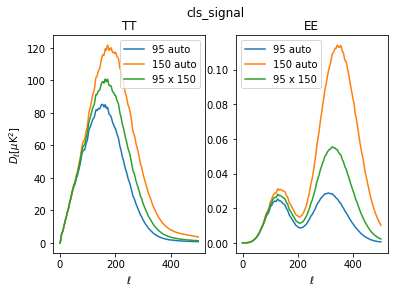

In [16]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(lfac * s['cls_signal']['tt']['95:95'], label='95 auto')
ax[0].plot(lfac * s['cls_signal']['tt']['150:150'], label='150 auto')
ax[0].plot(lfac * s['cls_signal']['tt']['150:95'], label='95 x 150')
ax[0].legend()
ax[0].set_ylabel(r'$D_\ell [\mu \mathrm{K}^2]$')
ax[0].set_xlabel(r'$\ell$')
ax[0].set_title('TT')
ax[1].plot(lfac * s['cls_signal']['ee']['95:95'], label='95 auto')
ax[1].plot(lfac * s['cls_signal']['ee']['150:150'], label='150 auto')
ax[1].plot(lfac * s['cls_signal']['ee']['150:95'], label='95 x 150')
ax[1].legend()
ax[1].set_xlabel(r'$\ell$')
ax[1].set_title('EE')
fig.suptitle('cls_signal')

This set of maps uses regular unimap reobserved constrained synfast sims for SPIDER. The Planck signal sims are not reobserved, but are smoothed to a uniform Gaussian with FWHM=15'. **Note:** XFaster is hardcoded to only expect Planck maps in this form. It does not solve for their transfer function (though that might change) and assumes if it is a Planck map, it has had its original beam deconvolved and smoothed with a common 15 arcmin Gaussian. So it's clear in these plots that the Planck maps have more power, since they both haven't had the heavy SPIDER filtering at low ell and the larger SPIDER beams applied at high ell.

The result of `get_masked_sims` is a spectrum per map cross per spectrum type (TT, EE, etc), which will ultimately be used to make up the $\tilde{\mathbf{D}}_\ell^{sig}$ matrix that we'll use for computing the transfer function in `get_transfer` below.

### get_beams

The next component we need for our equations is the beam window function, $B_\ell$. XFaster does not solve for this-- you have to tell it what it is. For SPIDER, we use the `beam20` product, and for Planck, we've smoothed each map to a common 15 arcmin Gaussian (which included deconvolving the original Planck beam for each map).

In `xfaster_exec`, there are optional arguments for this function if you have one ensemble of sims from which to compute the transfer function, and one from which to get the final shape spectrum expected. We used that in the past since transfer function calculation would go haywire at high ell since the beam had cut off so much power. Now, we just look at low ells, so we don't bother with this extra set of sims.

In [17]:
beams = X.get_beams(pixwin=True)

We could have a different beam for intensity and polarization. In practice, we don't, so each of the spectrum fields for beam is the same. Let's plot them for each map.

Text(0.5, 0, '$\\ell$')

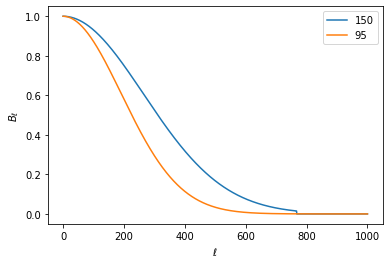

In [18]:
for freq in X.map_tags:
    plt.plot(beams['tt'][freq], label=freq)
plt.legend()
plt.ylabel(r'$B_\ell$')
plt.xlabel(r'$\ell$')

### get_signal_shape

Let's check in on our progress of components we've computed. We're trying to build everything to make up our $\tilde{\mathcal{C}}^{XY}_{b\ell}$s, which as a reminder are the following quantity.

\begin{equation}
\tilde{\mathcal{C}}^{XY}_{b\ell} = \sum_{\ell^{\prime}} K_{\ell \ell^{\prime}}^{X Y} F_{\ell^{\prime}}^{X Y} B_{\ell^{\prime}}^{2} \mathcal{C}_{\ell^{\prime}}^{X Y} \chi_{b}\left(\ell^{\prime}\right)
\end{equation}

We have $K_{\ell, \ell'}$ and $B_{\ell}$. For the transfer function calculation, we're going to set $F_\ell$ to 1 so that we measure $q_b$s as the deviation from a uniform transfer function for our simulations. Binning, $\chi_b$ has been chosen. All that's left is the full sky signal shape, $\mathcal{C}_{\ell'}^{XY}$. For calculating the transfer function, this is just the shape spectrum that went into making our simulations. The script we use to make the XFaster ensembles, `spider_tools/analysis/maps/xfaster_maps.py`, copies the spectrum it used to make the signal sim maps for reobservation into the top level of the signal sim directory. XFaster looks here for that spectrum, or you can explicitly feed the file in as an argument (the file must be an output file of CAMB-- XFaster expects that formatting and those units.)

In [19]:
signal_shape = X.get_signal_shape()

These will look familiar to you. Note that they are as long as the long dimension of the $K_{\ell\ell'}$, which is 2*lmax + 1.

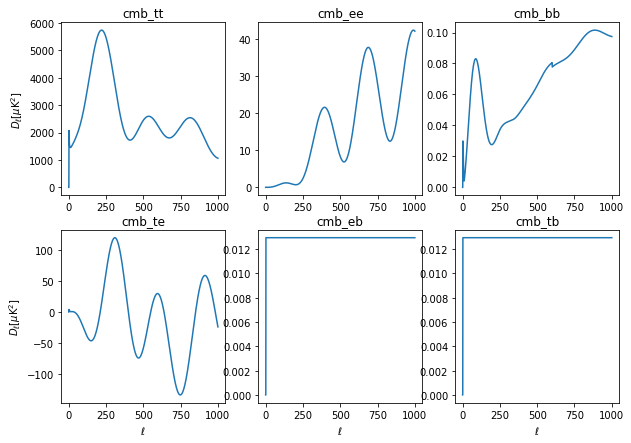

In [20]:
ell2 = np.arange(1001)
lfac2 = ell2 * (ell2 + 1) / (2*np.pi)
fig, ax = plt.subplots(2, 3, figsize=(10,7))
ax = ax.flatten()
for i, (s, spec) in enumerate(signal_shape.items()):
    ax[i].plot(lfac2 * spec)
    ax[i].set_title(s)
    if i in [0,3]:
        ax[i].set_ylabel(r'$D_\ell [\mu\mathrm{K}^2]$')
    if i in [3,4,5]:
        ax[i].set_xlabel(r'$\ell$')

### get_transfer

We now have everything we need to compute the transfer function, which is computed per map per spectrum per CMB bin. As a refresher, we're trying to get $q_b^{transfer}$, which is the same as our original expression for $q_b$ in Equation \ref{eq:qb}, except now we set noise=0, transfer function=1, and instead of using data for our observed signal, we use the ensemble average of our signal sims:

\begin{equation}
q_{b}^{transfer}=\frac{1}{2} \sum_{b^{\prime}} \mathcal{F}_{b b^{\prime}}^{-1} \sum_{\ell} (2 \ell+1) \operatorname{Tr}\left[ \left(\tilde{\mathbf{D}}_{\ell}^{-1} \frac{\partial \tilde{\mathbf{S}}_{\ell}}{\partial q_{b^{\prime}}} \tilde{\mathbf{D}}_{\ell}^{-1}\right)\mathbf{g}\tilde{\mathbf{D}}_{\ell}^{signal}\mathbf{g}^T\right]
\label{eq:qb_transfer}
\end{equation}

The expression for the Fisher matrix does not change, other than the fact that its constituents are the same as detailed above for the transfer function.

$\frac{\partial \tilde{\mathbf{S}}_{\ell}}{\partial q_{b^{\prime}}}$ is what's detailed in Equation $\ref{eq:dsdqb}$. For the transfer function, since we set noise to be zero, $\tilde{\mathbf{D}}_\ell$ is equivalent to $\tilde{\mathbf{S}}_\ell$ in Equation \ref{eq:qb_transfer}. 

Within the code, `get_transfer` basically has two steps within the function itself, which it performs per map. 
1. Load up the $\tilde{\mathcal{C}}_{b\ell}$: 
```python 
cbl = self.bin_cl_template(cls_shape_trf, m0, transfer_run=True)
```
`cls_shape_trf` is signal_shape that we calculated earlier, `m0` is the map, which is used to select the beam and kernel, and `transfer_run=True` sets the $F_\ell$ term to 1.
2. Run `fisher_iterate`.
```python
ret = self.fisher_iterate(cbl, cls_shape_trf, m0, transfer_run=True,
                          iter_max=iter_max, converge_criteria=converge_criteria,
                          save_iters=save_iters, cond_noise=cond_noise,
                          tophat_bins=tophat_bins)
```

We'll talk more in the `get_bandpowers` section about the details that happen from here, but broadly, XFaster takes all the inputs we've calculated and a starting $q_b$ guess (1 for all bins), computes the Fisher matrix, plugs that into the $q_b$ equation to get a new $q_b$, and repeats. Once the maximum of |(qb_new-qb)/qb| < converge_criteria, it stops iterating and saves the result.

One additional check that `get_transfer` does is to look for transfer function values that are negative. If it finds any, it changes that bin value to the average of the orignal value and the next bin's value. This typically happens due to poor choices of binning or too small a number of signal simulations.

Also, Only TT, EE, BB, and TE transfer functions are calculated. EB and TB are computed as
```python
qb['cmb_eb'] = np.sqrt(np.abs(qb['cmb_ee'] * qb['cmb_bb']))
qb['cmb_tb'] = np.sqrt(np.abs(qb['cmb_tt'] * qb['cmb_bb']))
```

In [21]:
print(signal_shape.keys())

odict_keys(['cmb_tt', 'cmb_ee', 'cmb_bb', 'cmb_te', 'cmb_eb', 'cmb_tb'])


In [22]:
transfer = X.get_transfer(signal_shape)

Let's look at a couple transfer functions.

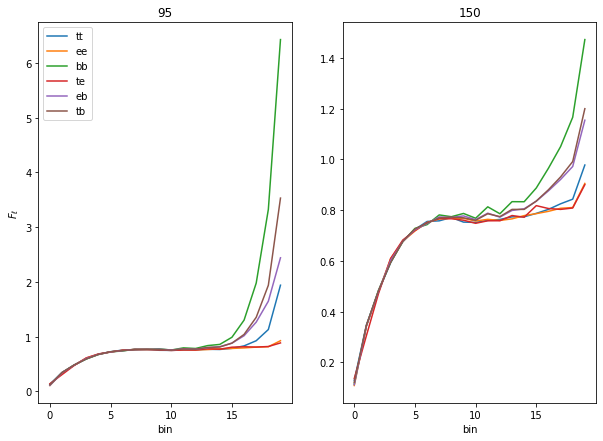

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax = ax.flatten()
plot_inds = {'95': 0, '150': 1}
for s, spec in transfer.items():
    for m, fl in spec.items():
        ax[plot_inds[m]].plot(fl, label=s.split('_')[-1])
        if 'tt' in s:
            ax[plot_inds[m]].set_title(m)
for i in range(2):
    ax[i].set_xlabel('bin')
for i in [0]:
    ax[i].set_ylabel(r'$F_\ell$')
ax[0].legend()

### get_bin_def (round 2)

Up to this point, we've been working towards getting the transfer function. Now, we want to set things up for solving for CMB bandpowers, and optionally foreground and/or noise residual bandpowers. We start by adding information about the binning we want for those terms to the `bin_def` dictionary.

In [24]:
bin_def = X.get_bin_def(bin_width=25, lmin=2, tbeb=True,
                        foreground_fit=False,
                        residual_fit=True, res_specs=['eebb'],
                        bin_width_res=100)

In [25]:
bin_def.keys()

odict_keys(['cmb_tt', 'cmb_ee', 'cmb_bb', 'cmb_te', 'cmb_eb', 'cmb_tb', 'res_eebb_150', 'res_eebb_95'])

So now we've set up everything we're going to solve for. Note that the residuals have a couple of unique features. Since we set `res_specs=['eebb']`, XFaster wills solve for a single amplitude for the EE and BB noise residuals. We could have instead set it to `['ee', 'bb']` or `['tt', 'ee', 'bb']`. The default at the moment is to solve for EE and BB together. Also note that noise residuals are fit per map, and that is to that map's auto-spectrum. We'll look more at that in the `get_bandpowers` section.

It's straightforward here to see how many parameters ($q_b$s) XFaster will be solving for-- just the total number of bins in bin_def: 120 for CMB, and 10 for noise residuals = 130.

In [26]:
from xfaster import parse_tools as pt
pt.dict_to_arr(bin_def).shape

(130, 2)

### get_masked_xcorr

In [27]:
cls_data = X.get_masked_data()

This is straightforward. It's using the healpy routines `map2alm` and `alm2cls` to get all the auto and cross spectra of the data maps. These are all built into the matrix $\tilde{\mathbf{D}}_\ell^{obs}$ in Equation \ref{eq:qb}. Let's look at a couple!

Text(0.5, 0.98, 'cls_data')

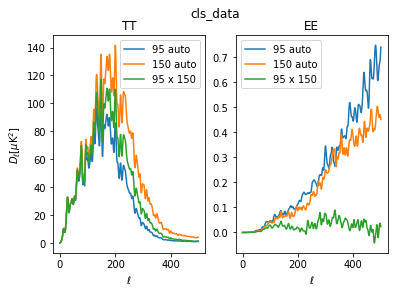

In [28]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(lfac * cls_data['cls_data']['tt']['95:95'], label='95 auto')
ax[0].plot(lfac * cls_data['cls_data']['tt']['150:150'], label='150 auto')
ax[0].plot(lfac * cls_data['cls_data']['tt']['150:95'], label='95 x 150')
ax[0].legend()
ax[0].set_ylabel(r'$D_\ell [\mu \mathrm{K}^2]$')
ax[0].set_xlabel(r'$\ell$')
ax[0].set_title('TT')
ax[1].plot(lfac * cls_data['cls_data']['ee']['95:95'], label='95 auto')
ax[1].plot(lfac * cls_data['cls_data']['ee']['150:150'], label='150 auto')
ax[1].plot(lfac * cls_data['cls_data']['ee']['150:95'], label='95 x 150')
ax[1].legend()
ax[1].set_xlabel(r'$\ell$')
ax[1].set_title('EE')
fig.suptitle('cls_data')

### get_masked_sims (round 2)

Now we do the same thing for all the sims. We've already done the signal sims since those were used for the transfer function, so the code sees that they're on disk and doesn't recompute them. It doesn't find the noise sims, so it computes those for each sim index for each auto and cross.

There are a few options you can use here. These options do not affect the ensemble average for signal and noise sims that are used to build the equations for $q_b$ and the Fisher matrix. Instead, they are for use when you don't want XFaster to compute bandpowers for data, but for simulations instead. If `ensemble_mean=True`, XFaster will replace the observed data matrix, $\tilde{\mathbf{D}}_\ell^{obs}$, with the ensemble average of signal plus the ensemble average of the noise sims. If `sim_index` is not None, it will replace the data matrix with the signal + noise spectra from the sim specified. If `sims_add_alms=True`, it will do that addition in $a_{\ell m}$s. If it is False, it will do the addition in $\tilde{\mathcal{C}}_\ell$s. The latter would not include signal cross noise; the former would.

In [29]:
sims = X.get_masked_sims(ensemble_mean=False, sim_index=None, sims_add_alms=True)

Now we have signal and noise in our sims dictionary. We've looked some signal spectra. Let's look at the same in noise.

Text(0.5, 0.98, 'cls_noise')

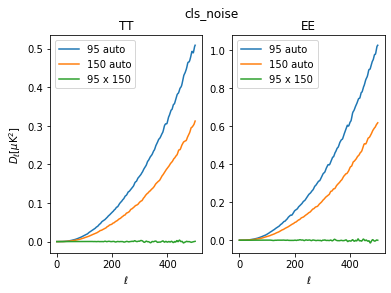

In [30]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(lfac * sims['cls_noise']['tt']['95:95'], label='95 auto')
ax[0].plot(lfac * sims['cls_noise']['tt']['150:150'], label='150 auto')
ax[0].plot(lfac * sims['cls_noise']['tt']['150:95'], label='95 x 150')
ax[0].legend()
ax[0].set_ylabel(r'$D_\ell [\mu \mathrm{K}^2]$')
ax[0].set_xlabel(r'$\ell$')
ax[0].set_title('TT')
ax[1].plot(lfac * sims['cls_noise']['ee']['95:95'], label='95 auto')
ax[1].plot(lfac * sims['cls_noise']['ee']['150:150'], label='150 auto')
ax[1].plot(lfac * sims['cls_noise']['ee']['150:95'], label='95 x 150')
ax[1].legend()
ax[1].set_xlabel(r'$\ell$')
ax[1].set_title('EE')
fig.suptitle('cls_noise')

### get_beams (round 2)

There's now another call to get_beams, which is totally superfluous if you're using the same signal sims for transfer functions that you are for your signal ensemble average. But, if you wanted to use a narrower beam for the former and a more realistic wider beam for the latter, this is where you'd load up the latter. For our case, we'll do it just so you can see the log message.

In [31]:
b = X.get_beams(pixwin=True)

### get_bandpowers

Now we put it all together!  The function `get_bandpowers` works just like `get_transfer`, with the transfer function terms no longer set to unity, and instead constructed from the $q_b$'s computed by `get_transfer`.

#### Constructing the model spectrum

The first step is to construct the $\tilde{\mathcal{C}}_{b\ell}$'s including all of the additional components in the model.  There are now two new pieces here: a foreground component that varies with frequency, and includes a linearized component for its spectral index, and so-called "noise residuals" that account for the inaccuracy of our noise model in the auto-spectra.

In [32]:
cbl = X.bin_cl_template(signal_shape, map_tag=None, transfer_run=False)

Let's plot up each set of components individually.  First, the CMB component, which should look familiar.  Each color represents the $\tilde{\mathcal{C}}_{b\ell}$ for a single bin.  The black lines show the total shape of each component in $\ell$, assuming the $q_b$ applied to each bin is set to 1.  This is what we call the *model spectrum* that we are fitting to.  Notice that the EE and BB mixing terms have very broad bins and are very low amplitude.  This is due to the shape of the $_{-}K_{\ell\ell^\prime}$ kernel as a function of $\ell$.  These shapes will look different for each map cross, due to differences in each transfer function and beam.

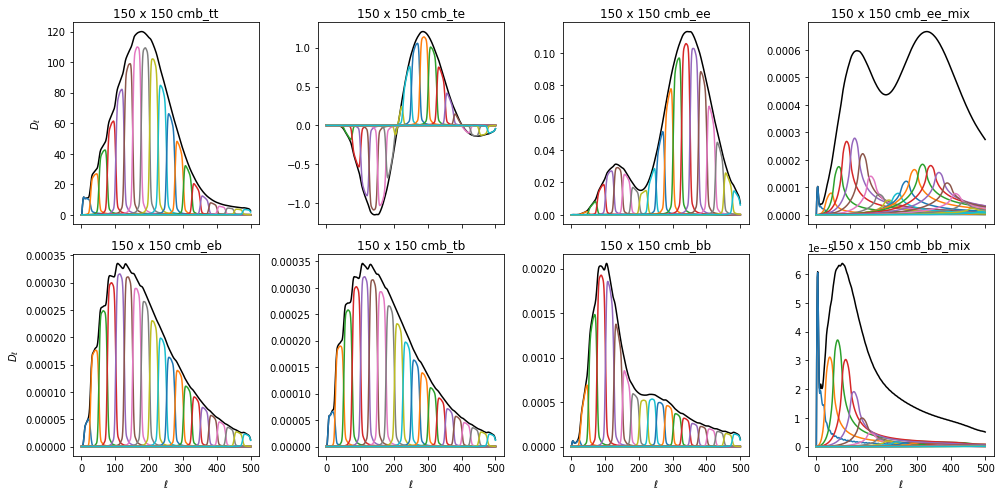

In [33]:
fig, axs = plt.subplots(2, 4, figsize=(14,7), sharex=True)
axs = axs.ravel()
ell = np.arange(501)
ellfac = ell * (ell + 1) / 2.0 / np.pi
comps = ['cmb_tt', 'cmb_te', 'cmb_ee', 'cmb_ee_mix', 'cmb_eb', 'cmb_tb', 'cmb_bb', 'cmb_bb_mix']
for ax, comp in zip(axs, comps):
    ax.set_title('150 x 150 {}'.format(comp))
    cbl1 = cbl[comp]['150:150']
    d = cbl1.sum(axis=0)
    ax.plot(d * ellfac, 'k')
    for d in cbl1:
        ax.plot(d * ellfac)
for i in [0,4]:
    axs[i].set_ylabel('$D_\ell$')
for i in range(4,8):
    axs[i].set_xlabel('$\ell$')
plt.tight_layout()

The next model component that we include accounts for residual noise in the auto-spectra.  These $\tilde{\mathcal{C}}_{b\ell}$ terms do not include any transfer functions, beams or mode mixing kernels.  They are derived from the *simulated* noise spectra $\tilde{N}_\ell$ that are subtracted from the *measured* data as in equation \ref{eq:qb}.  These terms act as corrections to the noise model by adjusting the auto-spectrum noise components to agree with the cross terms.

We fit only for the EE and BB components, and we do so in a simultaneous way.  That is, each $q_b^{res,EEBB}$ applies to both $\tilde{\mathcal{C}}_{b\ell}^{EE}$ and $\tilde{\mathcal{C}}_{b\ell}^{BB}$ here.  The TT spectrum is very much signal dominated, so we don't bother correcting TT auto spectra this way.

The residual signal model is thus:

\begin{equation}
\tilde{\mathbf{S}}_\ell^{res,ij} = \delta_{ij}\,
\begin{bmatrix}
0 & 0 & 0 \\ 
0 & \sum_b q_b^{EEBB} \tilde{\mathcal{C}}_{b\ell}^{EE} & 0 \\ 
0 & 0 & \sum_b q_b^{EEBB} \tilde{\mathcal{C}}_{b\ell}^{BB} \\ 
\end{bmatrix}_{\,res,ij}
\label{eq:signal_res}
\end{equation}

and the derivatives are

\begin{equation}
\frac{\partial \tilde{\mathbf{S}}_\ell}{\partial q_b^{res,ij,EEBB}} = \delta_{ij}\,
\begin{bmatrix}
0 & 0 & 0 \\ 
0 & \tilde{\mathcal{C}}_{b\ell}^{EE} & 0 \\ 
0 & 0 & \tilde{\mathcal{C}}_{b\ell}^{BB} \\ 
\end{bmatrix}_{\,res,ij}
\label{eq:signal_res_deriv}
\end{equation}

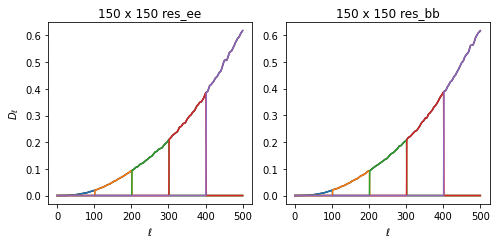

In [34]:
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(7,3.5))
axs = axs.ravel()
ell = np.arange(501)
ellfac = ell * (ell + 1) / 2.0 / np.pi
comps = ['res_ee', 'res_bb']
for ax, comp in zip(axs, comps):
    ax.set_title('150 x 150 {}'.format(comp))
    cbl1 = cbl[comp]['150:150']
    d = cbl1.sum(axis=0)
    ax.plot(d * ellfac, 'k')
    for d in cbl1:
        ax.plot(d * ellfac)
for i in [0]:
    axs[i].set_ylabel('$D_\ell$')
for i in range(2):
    axs[i].set_xlabel('$\ell$')
plt.tight_layout()

Next we add our actual noise simulations to the model.  The residual noise terms discussed above are designed to account for inaccuracies in this model.  We assume that the cross terms are accurate, and only correct the auto spectra for EE and BB in this way.

We often find that the fisher iterations have trouble converging due to degeneracies in the lower bins, so we also include a term we call "conditioning noise" along the TT/EE/BB diagonals as well.  The conditioning noise is modeled as:

\begin{equation}
\tilde{\mathbf{S}}_\ell^{cond,ij,XY} = \delta_{ij} c_{XY} \frac{\ell + 1}{\ell^2}
\end{equation}

where $c_{EE} = c_{BB}$ is parameterized by the `cond_noise` option, typically a small number O(0.01) or less, $c_{TT} = 100 c_{EE}$ and all others are 0.

To plot up both of these model components, along with all of the terms discussed above, let's call an internal function that computes the model spectrum for us, given the $\tilde{\mathcal{C}}_{b\ell}$ terms and some model parameters $q_b$.

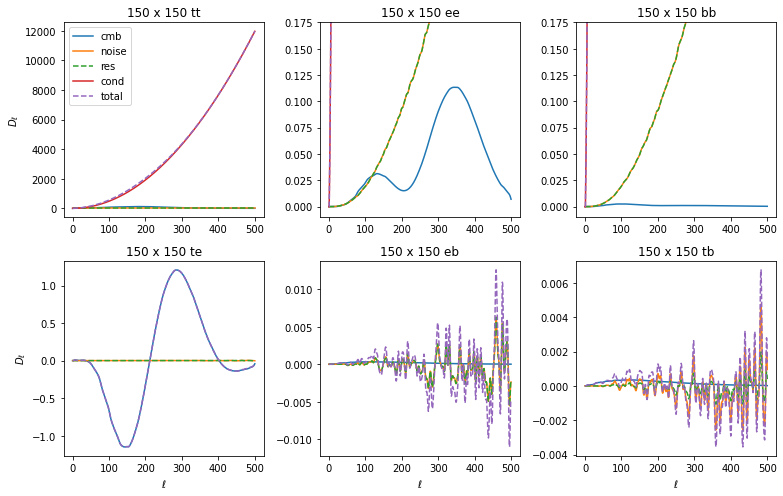

In [35]:
from collections import OrderedDict
# construct a dummy qb array to compute input model
qb = OrderedDict([(k, np.ones(len(v))) for k, v in X.bin_def.items()])
cls_model = X.get_model_spectra(qb, cbl, delta=True, cls_noise=X.cls_noise, cond_noise=0.03)

fig, axs = plt.subplots(2, 3, figsize=(11,7))
axs = axs.ravel()
ell = np.arange(501)
ellfac = ell * (ell + 1) / 2.0 / np.pi
xname = '150:150'
for comp in ['cmb', 'noise', 'res', 'cond', 'total']:
    for ax, spec in zip(axs, ['tt', 'ee', 'bb', 'te', 'eb', 'tb']):
        stag = '{}_{}'.format(comp, spec)
        if stag not in cls_model:
            ax.plot(0, 0, label=comp)
            continue
        if comp in ['res', 'total']:
            ax.plot(ellfac * cls_model[stag][xname], label=comp, linestyle='--')
        else:
            ax.plot(ellfac * cls_model[stag][xname], label=comp)
        ax.set_title('150 x 150 {}'.format(spec))
        if spec in ['ee', 'bb']:
            ax.set_ylim(-0.01, 0.175)
axs[0].legend()
for i in [0,3]:
    axs[i].set_ylabel('$D_\ell$')
for i in range(3,6):
    axs[i].set_xlabel('$\ell$')
plt.tight_layout()

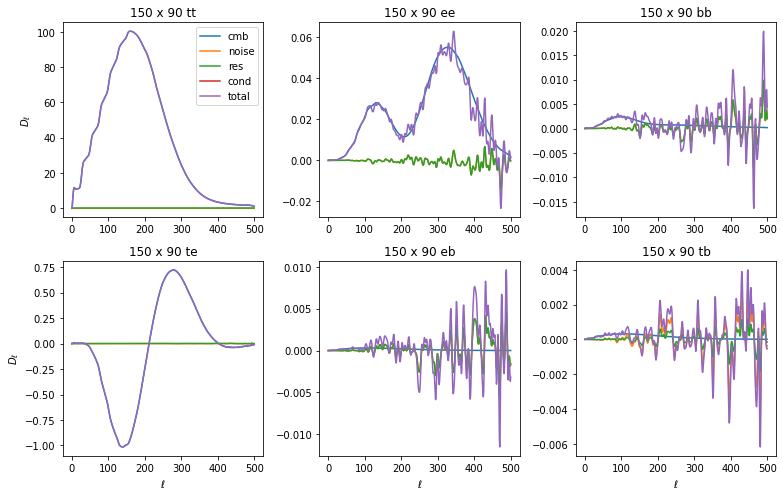

In [36]:
fig, axs = plt.subplots(2, 3, figsize=(11,7))
axs = axs.ravel()
ell = np.arange(501)
ellfac = ell * (ell + 1) / 2.0 / np.pi
xname = '150:95'
for comp in ['cmb', 'noise', 'res', 'cond', 'total']:
    for ax, spec in zip(axs, ['tt', 'ee', 'bb', 'te', 'eb', 'tb']):
        stag = '{}_{}'.format(comp, spec)
        if stag not in cls_model or xname not in cls_model[stag]:
            ax.plot(0, 0, label=comp)
            continue
        ax.plot(ellfac * cls_model[stag][xname], label=comp)
        ax.set_title('150 x 90 {}'.format(spec))
axs[0].legend()
for i in [0,3]:
    axs[i].set_ylabel('$D_\ell$')
for i in range(3,6):
    axs[i].set_xlabel('$\ell$')
plt.tight_layout()

Note that neither conditioning noise nor residual terms are present in the 150x90 spectra.

Note also that the shape of the conditioning noise is counter-intuitive.  It should be largest at low ell to improve convergence, but it is not.  This seems like a bug.

#### Computing the Fisher matrix

Ok! Now that we have all the pieces in place, all that's left is to do some matrix math and iterate over equations \ref{eq:qb} and \ref{eq:fisher} until the results converge.  The two equations are constructed in the function `fisher_calc`, which is called iteratively by `fisher_iterate` until convergence is reached.

In order to make all the quantities we've computed look like matrices, we have two utility functions, `dict_to_dmat` and `dict_to_dsdqb_mat`, that convert the dictionaries `Dmat1` (corresponding to $\mathbf{D}_\ell$ in the equations) and `dSdqb_mat1_freq` ($\partial \mathbf{S}_\ell / \partial q_b$) into matrices.

The `Dmat1` matrix has shape `(3 * num_maps, 3 * num_maps, lmax + 1)` and contains the `total` model terms for each map cross spectrum, ordered as in equation \ref{eq:dell}.  The `dSdqb_mat1_freq` matrix has shape `(3 * num_maps, 3 * num_maps, nbins, lmax + 1)` and includes the CMB, residuals and frequency-corrected foreground components for all the crosses. We then compute the quantity

\begin{equation}
\mathbf{D}^{-1} \frac{\partial \mathbf{S}}{\partial q_b} \mathbf{D}^{-1}
\end{equation}

using the following code:

```python
Dmat1 = np.linalg.inv(Dmat1.swapaxes(0, -1)).swapaxes(0, -1)
eye = np.eye(len(gmat))
mat1 = np.einsum('ij...,jk...->ik...', eye, Dmat1)
mat2 = np.einsum('klm...,ln...->knm...', dSdqb_mat1_freq, Dmat1)
mat = np.einsum('ik...,knm...->inm...', mat1, mat2)
```

The first line computes the inverse of $D$, ell-by-ell along the first two dimensions.  The next two lines are necessary due to some quirk of memory access in python; this is just multiplying the first two dimensions of `Dmat1` by the identity matrix.  The last two lines do the matrix multiplication along the first two dimensions of each of the matrices.

Now, we apply the $\mathbf{g}$ correction factor as in equations \ref{eq:qb} and \ref{eq:fisher}.  The following two lines multiply $\mathbf{gg}^T$ element-by-element along the first two dimensions of `Dmat_obs` and `dSdqb_mat1_freq`.

```python
Dmat_obs_g = gmat[..., None] * Dmat_obs
dSdqb_mat1_g = gmat[..., None, None] * dSdqb_mat1_freq
```

Next we compute the big matrices in equations \ref{eq:qb} and \ref{eq:fisher} and compute their traces in a single step:

```python
matd = np.einsum('ijk...,ji...->k...', mat, Dmat_obs_g)
mats = np.einsum('ijk...,jil...->kl...', mat, dSdqb_mat1_g)
```

And finally, we sum over $\ell$ to compute $v_b = \sum_b' \mathcal{F}_{bb^\prime}q_{b'}$ and $\mathcal{F}_{bb^\prime}$. $v_b$ now just needs the inverse Fisher matrix applied to it to get $q_b$.

```python
qb_vec = np.dot(matd, ellfac) / 2.0
fisher = np.dot(mats, ellfac) / 2.0
```

#### Inverting the Fisher matrix

Now we take the inverse.  The `solve` function in the `numpy.linalg` library does so efficiently:

```python
qb_vec = np.linalg.solve(fisher, qb_vec)
inv_fish = np.linalg.solve(fisher, np.eye(len(qb_vec)))
```

With each iteration, we compare the new `qb_vec` quantity to the previous one, until the maximum fractional change in any element of the array is less than the convergence criterion (0.005 is typical).

#### Constructing final bandpowers

To construct bandpowers, we need to apply the $q_b$ parameters to the input shape spectra.  This is done by integrating over each bin using a weighting scheme.  The quantity we want in the end should be in units of $\mathcal{D}_\ell = \ell (\ell + 1) C_\ell / 2\pi$, where $C_\ell$ is the appropriate input shape spectrum.
Assuming some weighted integral $\mathcal{I}_b$ for a given bin, we compute each bandpower as a weighted integral of $\ell (\ell + 1) C_\ell / 2\pi$, scaled by the appropriate $q_b$, and normalized by the integral of the weights:

\begin{equation}
\mathcal{D}_b = q_b \frac{ \mathcal{I}_b\left[\frac{\ell (\ell + 1)}{2\pi} C_\ell \right] }{ \mathcal{I}_b\left[ 1 \right] }
\end{equation}

Similarly, the errors on each bandpower are:

\begin{equation}
\Delta\mathcal{D}_b = \sqrt{F^{-1}_{bb}} \frac{ \mathcal{I}_b\left[\frac{\ell (\ell + 1)}{2\pi} C_\ell \right] }{ \mathcal{I}_b\left[ 1 \right] }
\end{equation}

To be specific, we define the weighted integral as:

\begin{equation}
\mathcal{I}_b\left[f_\ell\right] = \sum_\ell \frac{1}{2} \frac{2\ell + 1}{\ell (\ell + 1)} \chi_b(\ell) \, f_\ell
\end{equation}

where $\chi_b(\ell)$ is a top-hat function with value 1 within the bin and 0 outside of it. This weighting scheme is taken from [Section 4.2 of Bond, Jaffe, and Knox (2000)](https://arxiv.org/pdf/astro-ph/9808264.pdf). With this definition, the bin centers are:

\begin{equation}
\ell_b = \frac{ \mathcal{I}_b\left[\frac{\ell (\ell + 1)}{2\pi} C_\ell \, \ell \right] }{ \mathcal{I}_b\left[ \frac{\ell (\ell + 1)}{2\pi} C_\ell \right] }
\end{equation}

While this definition of the integral is sufficient, the more accurate calculation constructs $\chi_b(\ell)$ as a window function that includes beam, transfer function and kernel effects that distribute power as a function of $\ell$.  This has yet to be implemented.

## Looking at results

In [37]:
bp = X.get_bandpowers(signal_shape, converge_criteria=0.005, iter_max=200, save_iters=True,
                      cond_noise=0.03)

/github/workspace/xfaster/xfaster_class.py:1758: XFasterWarning: Error loading ../outputs_example/95x150/bandpowers_95x150.npz: Field delta_beta_prior has value 0.5, expected None
  self.warn(
[ 2021-04-30 20:48:11UTC ] INFO: Doing Fisher step 1/200...


[ 2021-04-30 20:48:11UTC ] INFO: Max fractional change in qb: 34792.46533696417


[ 2021-04-30 20:48:11UTC ] INFO: Doing Fisher step 2/200...


[ 2021-04-30 20:48:12UTC ] INFO: Max fractional change in qb: 4.001747465650029


[ 2021-04-30 20:48:12UTC ] INFO: Doing Fisher step 3/200...


[ 2021-04-30 20:48:13UTC ] INFO: Max fractional change in qb: 0.39435293400196486


[ 2021-04-30 20:48:13UTC ] INFO: Doing Fisher step 4/200...


[ 2021-04-30 20:48:14UTC ] INFO: Max fractional change in qb: 0.14523037503541208


[ 2021-04-30 20:48:14UTC ] INFO: Doing Fisher step 5/200...


[ 2021-04-30 20:48:14UTC ] INFO: Max fractional change in qb: 0.065114055233929


[ 2021-04-30 20:48:15UTC ] INFO: Doing Fisher step 6/200...


[ 2021-04-30 20:48:15UTC ] INFO: Max fractional change in qb: 0.031194814787052695


[ 2021-04-30 20:48:15UTC ] INFO: Doing Fisher step 7/200...


[ 2021-04-30 20:48:16UTC ] INFO: Max fractional change in qb: 0.015354280885449342


[ 2021-04-30 20:48:16UTC ] INFO: Doing Fisher step 8/200...


[ 2021-04-30 20:48:17UTC ] INFO: Max fractional change in qb: 0.00764789616619951


[ 2021-04-30 20:48:17UTC ] INFO: Doing Fisher step 9/200...


[ 2021-04-30 20:48:17UTC ] INFO: Max fractional change in qb: 0.0038299775316740256


[ 2021-04-30 20:48:18UTC ] INFO: Calculating final Fisher matrix.


[ 2021-04-30 20:48:18UTC ] INFO: Calculating final Fisher matrix without sample variance.


In the plot below, we'll plot up the maximum fractional change in $q_b$ with iteration. This information is printed in the logs, but it's helpful to visualize on a plot. You can see it bounce around early on before settling down and ultimately stopping once it gets to the desginated criterion.

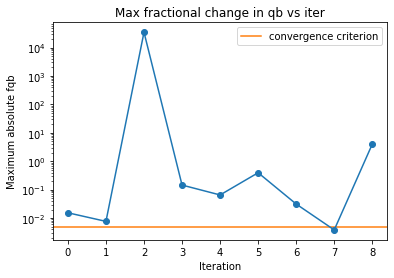

In [38]:
import glob
iters = glob.glob('../outputs_example/95x150/bandpowers_iter*')
### Figure for seeing how convergence looks in fqb
fig_fqb, ax_fqb = plt.subplots()
ax_fqb.axhline(0.005, label='convergence criterion', color='C1')
ax_fqb.set_title('Max fractional change in qb vs iter')
ax_fqb.set_ylabel('Maximum absolute fqb')
ax_fqb.set_xlabel('Iteration')
fqb = np.zeros(len(iters))
for i, bp0 in enumerate(iters):
    b = xf.load_and_parse(bp0)
    fqb[i] = np.max(np.abs(b['fqb']))
ax_fqb.plot(fqb, marker='o')
ax_fqb.legend()
ax_fqb.set_yscale('log')

Now let's see how the total model (summing up the $q_b\mathcal{C}_{b\ell}$ terms for every component) to see how it converges to fit the data. Within a few iterations, it's quite close.

Text(0.5, 0.98, '90$\\times$150 GHz total power fit')

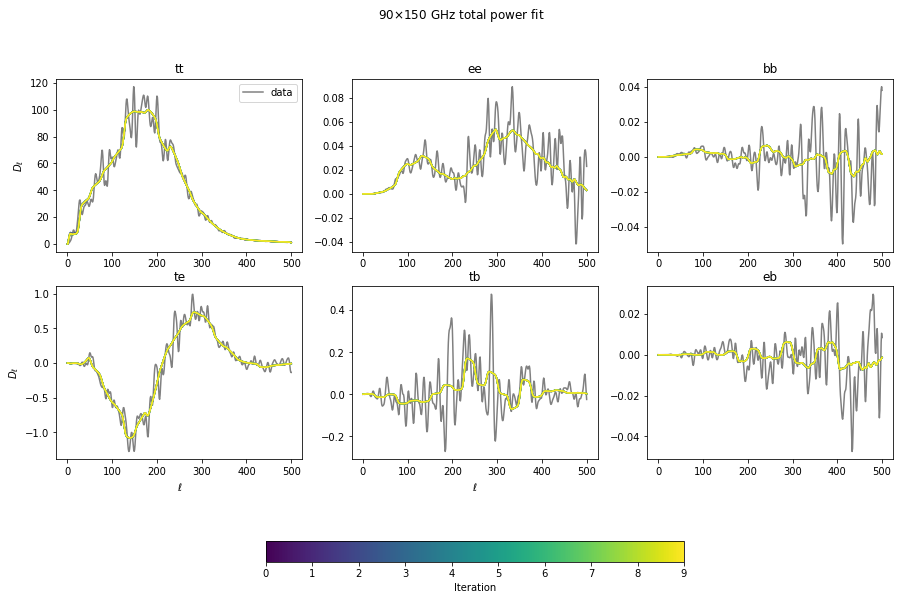

In [39]:
### Figure for looking at how sum(qbCbl) changes with iteration to match data
figtmp = plt.figure()
tmpplot = plt.imshow(np.zeros((2,2)), cmap=plt.cm.get_cmap('viridis'),vmin=0, vmax=len(iters))
plt.close(figtmp)
fig_dat, ax_dat = plt.subplots(2,3, figsize=(15,10))
ax_dat = ax_dat.flatten()
specs = ['tt', 'ee', 'bb', 'te', 'tb', 'eb']
colors = plt.cm.get_cmap('viridis', len(iters)).colors
for s, spec in enumerate(specs):
    ax_dat[s].set_title(spec)
for i, bp0 in enumerate(iters):
    b = xf.load_and_parse(bp0)
    for s, spec in enumerate(specs):
        if i == 0:
            # data cls don't change with iter- plot once.
            ax_dat[s].plot(b['cls_obs'][spec]['150:95'] * lfac, color='gray', label='data')
        ax_dat[s].plot(b['cls_model']['total_'+spec]['150:95'] * lfac, color=colors[i])
for i in [0, 3]:
    ax_dat[i].set_ylabel(r'$D_\ell$')
for i in range(3,5):
    ax_dat[i].set_xlabel(r'$\ell$')
ax_dat[0].legend()
fig_dat.colorbar(tmpplot, label='Iteration', ax=ax_dat.ravel().tolist(), 
                 orientation='horizontal', shrink=0.5)

fig_dat.suptitle(r'90$\times$150 GHz total power fit')

Now let's look at just the $q_b$ values for each of the different component and see how they converge as a function of iteration and bin. The lowest bins tend to have the biggest moves, but for all components, everything gets close to its final value within a handful of iterations.

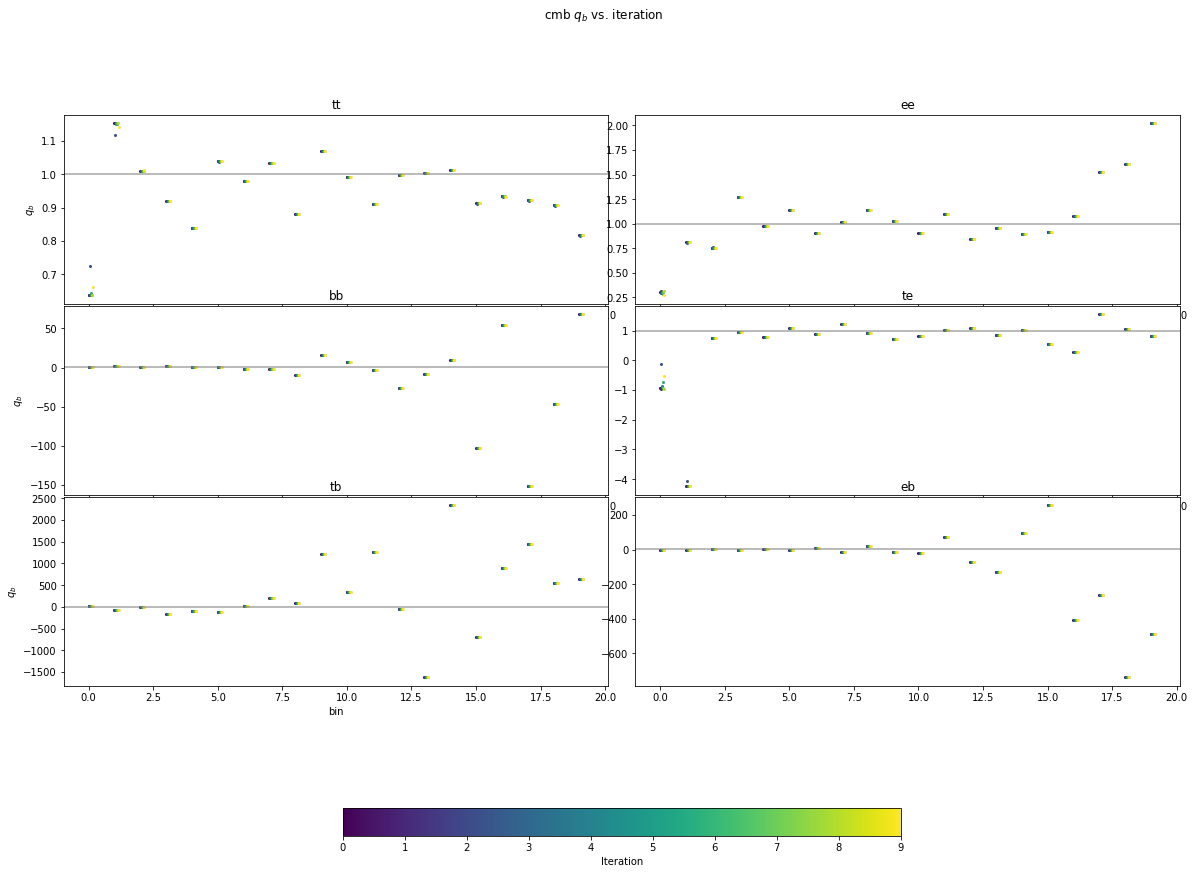

In [40]:
### Figure for looking at how qb for each bandpower changes with iteration
figtmp = plt.figure()
tmpplot = plt.imshow(np.zeros((2,2)), cmap=plt.cm.get_cmap('viridis'),vmin=0, vmax=len(iters))
plt.close(figtmp)
specs = ['tt', 'ee', 'bb', 'te', 'tb', 'eb']
colors = plt.cm.get_cmap('viridis', len(iters)).colors
scatter = 1. / 50.
for comp in ['cmb']:
    fig_dat, ax_dat = plt.subplots(3,2, figsize=(20,15))
    fig_dat.suptitle(comp+r' $q_b$ vs. iteration')
    ax_dat = ax_dat.flatten()
    for s, spec in enumerate(specs):
        ax_dat[s].set_title(spec)
        ax_dat[s].axhline(1, color='gray', alpha=0.7)
    for i, bp0 in enumerate(iters):
        b = xf.load_and_parse(bp0)
        for s, spec in enumerate(specs):
            ax_dat[s].scatter(np.arange(20) + scatter * i, 
                              b['qb'][comp+'_'+spec], color=colors[i], s=4)
    for i in [0, 2, 4]:
        ax_dat[i].set_ylabel(r'$q_b$')
    for i in range(4,5):
        ax_dat[i].set_xlabel('bin')

    plt.subplots_adjust(wspace=0.05, hspace=0.01)
    fig_dat.colorbar(tmpplot, label='Iteration', ax=ax_dat.ravel().tolist(), 
                     orientation='horizontal', shrink=0.5)


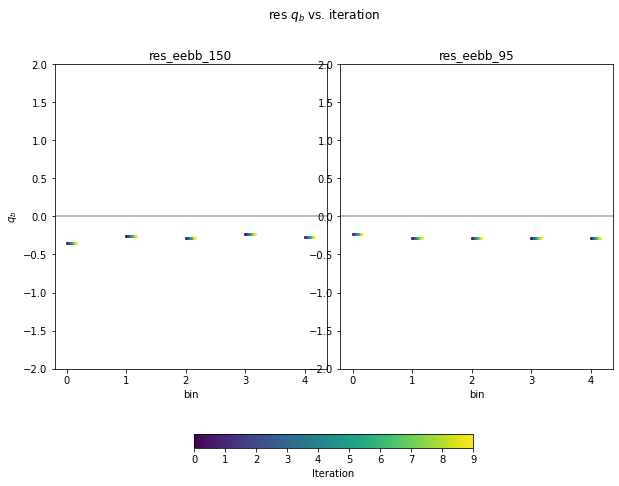

In [41]:
# Now plot residuals
fig_dat, ax_dat = plt.subplots(1,2, figsize=(10,8))
fig_dat.suptitle(r'res $q_b$ vs. iteration')
ax_dat = ax_dat.flatten()
maps = [x for x in b['qb'] if 'res' in x]
for s, m0 in enumerate(maps):
    ax_dat[s].set_title(m0)
    ax_dat[s].axhline(0, color='gray', alpha=0.7)
    ax_dat[s].set_ylim(-2,2)
for i, bp0 in enumerate(iters):
    b = xf.load_and_parse(bp0)
    for s, m0 in enumerate(maps):
        ax_dat[s].scatter(np.arange(5) + scatter * i, 
                          b['qb'][m0], color=colors[i], s=4)
for i in [0]:
    ax_dat[i].set_ylabel(r'$q_b$')
for i in range(2):
    ax_dat[i].set_xlabel('bin')

plt.subplots_adjust(wspace=0.05, hspace=0.01)
fig_dat.colorbar(tmpplot, label='Iteration', ax=ax_dat.ravel().tolist(), 
                 orientation='horizontal', shrink=0.5)

Now that everything has converged, let's plot up what the final bandpowers and error bars look like. XFaster saves the binned bandpowers as $D_\ell$s, though they are labeled `cb`. The error bars are in `dcb`, and those are also computed without sample variance in `dcb_nosampvar`. Covariance is in `cov`, and it also has a no sample variance version, `cov_nosampvar`. I'll plot up the starting models as well to see how far XFaster had to adjust to match the data.

To calculate error bars and covariances without sample variance, XFaster just does one final calculation of the Fisher matrix (after everything has converged), with all the $q_b$s set to a very small number, thereby nulling out the signal. The error bars and covariance without sample variance come from that Fisher matrix.

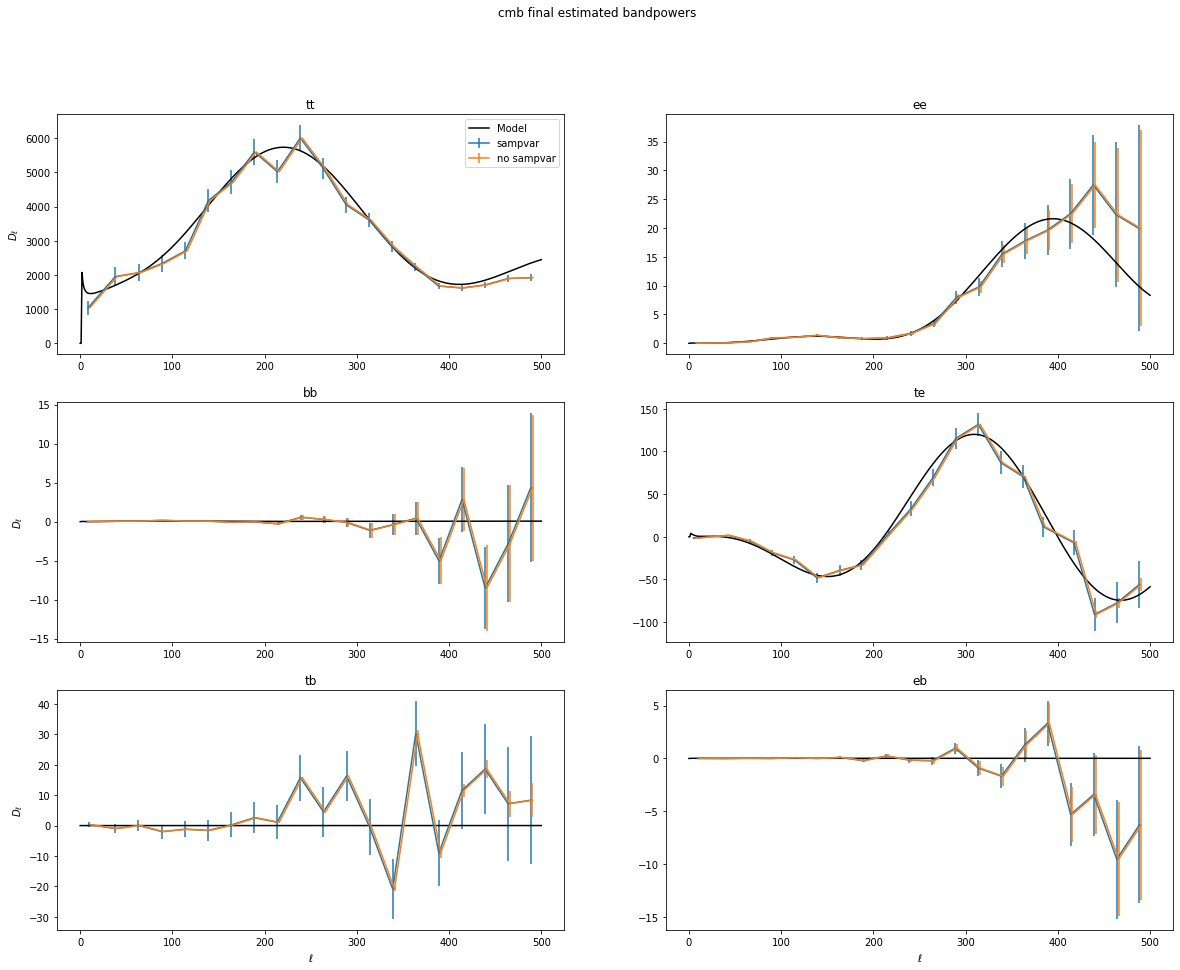

In [42]:
#bp = xf.load_and_parse('/mnt/scratch1/spectra_spider_planck/sp_pl/bandpowers_sp_pl.npz')
for comp in ['cmb']:
    fig, ax = plt.subplots(3,2, figsize=(20,15))
    ax = ax.flatten()
    fig.suptitle('{} final estimated bandpowers'.format(comp))
    for s, spec in enumerate(specs):
        sn = '{}_{}'.format(comp, spec)
        ax[s].set_title(spec)
        ax[s].plot(lfac * signal_shape[sn][:501], 'k-', label='Model')     
        ax[s].errorbar(bp['ellb'][sn], bp['cb'][sn], bp['dcb'][sn], label='sampvar') 
        ax[s].errorbar(bp['ellb'][sn]+2, bp['cb'][sn], bp['dcb_nosampvar'][sn], label='no sampvar')
    ax[0].legend()
    for i in [0, 2, 4]:
        ax[i].set_ylabel(r'$D_\ell$')
    for i in [4,5]:
        ax[i].set_xlabel(r'$\ell$')

The error bars are just the diagonal of the covariance matrix. Is this a good approximation for our real error? Let's look at the covariance matrix with and without sample variance.

Text(0.5, 1.0, 'Without sample variance')

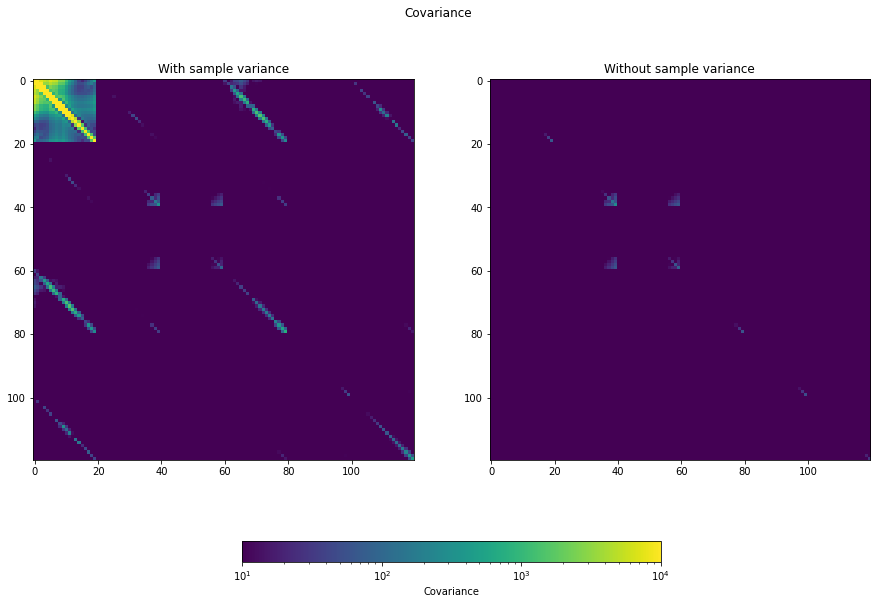

In [43]:
from matplotlib.colors import LogNorm
norm = LogNorm(vmin=10, vmax=1e4)
fig, ax = plt.subplots(1, 2, figsize=(15,10))
fig.suptitle('Covariance')
p = ax[0].imshow(np.abs(bp['cov']), norm=norm)
ax[0].set_title('With sample variance')
ax[1].imshow(np.abs(bp['cov_nosampvar']), norm=norm)
fig_dat.colorbar(p, label='Covariance', ax=ax.ravel().tolist(), 
                 orientation='horizontal', shrink=0.5)
ax[1].set_title('Without sample variance')

This is a 120 x 120 bin matrix, with each of the 20 bins for each spectrum in order (TT, EE, BB, TE, EB, TB).

## Other useful things

* **Null tests**
 * To run a null test, you just provide two data roots (`data_root` and `data_root2`) corresponding to the map directories of the two halves of the null. 
 * When XFaster is computing $\mathcal{C}_\ell$s from signal sims, noise sims, and data, it loads up both maps, and then computes the spectrum both of (map1+map2)/2 and (map1-map2)/2. It uses the former to compute transfer functions, and the latter for bandpowers.
 * The model spectrum fit for is flat in $D_\ell$ with an amplitude of 1e-5 (0 causes singular matrix problems in the Fisher computation). 
* **Foreground sims**
 * If you have some foreground sims, say from PySM sitting on disk, and you want XFaster to add them to a CMB signal sim, then in addition to setting `sim_index` to your desired CMB signal sim index, set `foreground_type`. This argument works the same way as `clean_type`-- it looks for maps in the directory in your data root in the folder `foreground_<foreground_type>` that match the map tags you asked for in `data_subset`. 
* `noise_type_sim`
 * SPIDER's noise sims aren't a super good estimate of our actual noise. That's why we fit for noise residuals! If you want to run a sim that tests how well this works, you can use a different noise sim than one from your ensemble used to calculate $<N_\ell>$ when doing a `sim_index` run. Feed the tag for the other noise sim directory to `noise_type_sim` (works just like `noise_type`) to use a sim with the same sim index from that directory instead.